<div class="alert alert-block alert-info">
    <h1>Arrhythmia classification in ECG signals using graph representation and Graph Neural Network</h1>
 </div>

<div class="alert alert-block alert-info">
    <h1>Importing packages</h1>
 </div>

In [1]:
%pylab inline
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob
import math
import networkx as nx
import igraph as ig
import os
import random
import pickle
import sys
import urllib.request
import pywt
import json
import scipy
import warnings
import dgl
import torch as th
import dgl.nn.pytorch as dglnn
import torch.nn as nn
import torch.nn.functional as F
from dgl.data.utils import save_graphs, load_graphs
from dgl.dataloading import GraphDataLoader
from dgl.data import DGLDataset
from dgl.nn import GraphConv, SAGEConv, GINConv, GATConv, DenseSAGEConv
from torch_geometric.loader import DataLoader
from json import JSONEncoder
from ts2vg import NaturalVG
from scipy.io import loadmat, savemat
from scipy import signal
from collections import Counter, defaultdict
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

Populating the interactive namespace from numpy and matplotlib


Using backend: pytorch
C:\Users\rafae\miniconda3\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


<div class="alert alert-block alert-info">
    <h1>Loading files</h1>
 </div>

Loading the files of ECG signals. The MIT-BIH has 48 records from 47 subjects. Following the AAMI recommendation, 04 records were excluded because these signals have paced beats. So, the next cell, I split the dataset into two dataset: training and test sets following the [De Chazal](https://ieeexplore.ieee.org/abstract/document/1306572) recommendation.

In [2]:
path_normalized = '../Datasets/MIT_normalized/' #normalized data
path = '../Datasets/MIT/' #original data
files_mat = os.listdir(path) #list the signals files

In [3]:
#splitting data in training and test by De Chazal proposed method
files_train = ['101.mat','106.mat','108.mat','109.mat','112.mat','114.mat','115.mat',
              '116.mat','118.mat','119.mat','122.mat','124.mat','201.mat','203.mat',
              '205.mat','207.mat','208.mat','209.mat','215.mat','220.mat','223.mat','230.mat']
files_test = ['100.mat','103.mat','105.mat','111.mat','113.mat','117.mat','121.mat',
              '123.mat','200.mat','202.mat','210.mat','212.mat','213.mat','214.mat',
              '219.mat','221.mat','222.mat','228.mat','231.mat','232.mat','233.mat','234.mat']

<div class="alert alert-block alert-info">
    <h1>Normalization Z-score</h1>
 </div>

The normalization is used to normalized the amplitude of the signals using Z-score normalization. This normalization uses mean and standard deviation from signal values by bellow formula:

$$\textrm{Values normalized} = \dfrac{\textrm{signal values} - \textrm{mean signal of values}}{\textrm{standard deviation of signal values}}$$

GNN will be trained with two different signals to compare the performace of the model: 
+ original signals
+ normalized signals

In [25]:
def normalize_beats(path_save, path_open, list_files):
    for file in list_files:

        struct = loadmat(path_open + file) #loading the file
        data = struct['individual'][0][0] #loading info of the signal
        ecg = data['signal_r'][:, 1] #reading lead II

        norm_signal = stats.zscore(ecg) #applying zscore in signal

        savemat(path_save+file, {'data':norm_signal}) #save the signals

In [26]:
normalize_beats(path_normalized,path,files_mat) #applying normalization

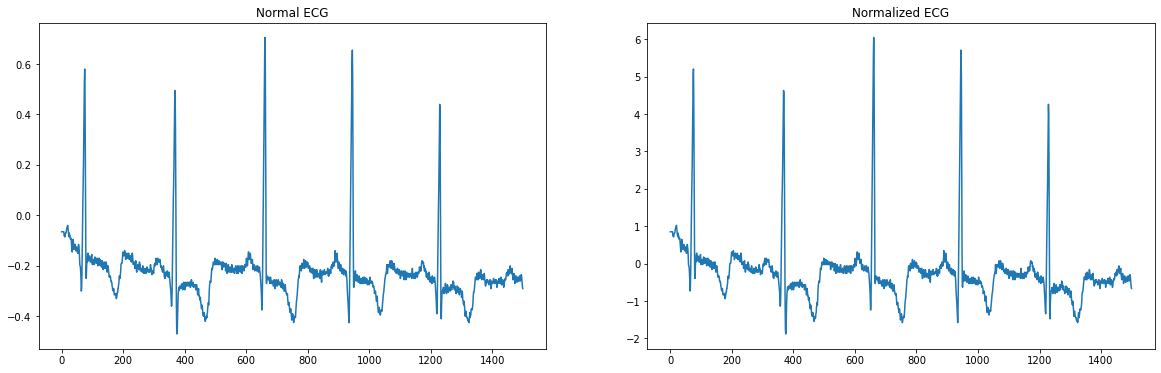

In [4]:
#checking the normal and normalized signal
fig, ax = plt.subplots(1,2,figsize=(20,6))

struct = loadmat(path + files_mat[0]) #loading the file
data = struct['individual'][0][0] #loading info of the signal
ecg = data['signal_r'][:, 1] #reading lead II

struct_norm = loadmat(path_normalized + files_mat[0])
ecg_norm = struct_norm['data'][0]

#plotting signals
ax[0].plot(ecg[0:1500])
ax[1].plot(ecg_norm[0:1500])
ax[0].set_title('Normal ECG')
ax[1].set_title('Normalized ECG')
plt.show()

<div class="alert alert-block alert-info">
    <h1>Segmentation</h1>
 </div>

The segmentation will use length of window of 300 samples. Each beat will labeled with type of arrhythmia provided by MIT-BIH database. Each signals has two leads, lead I and lead II. Here, I used only lead II.

In [52]:
def load_signals(path, list_ecgs, size_beat, file_name, path_denoised=0):
    dict_signals = defaultdict(list) #dict to load beats
    
    for file in list_ecgs:               
     
        struct = loadmat(path + file) #loading the original file
        data = struct['individual'][0][0] #loading info of the signal
        ecg = data['signal_r'][:, 1] #reading lead II
        beat_peaks = data['anno_anns'] #reading R-peak
        beat_types = data['anno_type'] #reading type of beat
        
        #struct_denoised = loadmat(path_denoised+file) #loading the denoised file
        #ecg = struct_denoised['data'][0] #loading info of the signal

        for peak, beat_type in zip(beat_peaks, beat_types):
            
            beat_samples=[] #list to save samples of beat
            
            half_beat = int(size_beat/2) #half of size beat

            #if the position is before the begining or 
            #if the position is after the ending
            #do nothing
            if (peak - half_beat) < 0 or (peak + half_beat) > len(ecg):
                continue
            
            #if type of beat is different than this list, do nothing
            if beat_type not in 'NLRejAaJSVEFP/fUQ':
                continue

            #taking the samples of beat window
            beat_samples = ecg[int(peak - half_beat):int(peak + half_beat)]
            
            #taking the type of beat and saving in dict
            if beat_type in 'NLRej':
                dict_signals['N'].append(beat_samples)
            elif beat_type in 'AaJS':
                dict_signals['S'].append(beat_samples)
            elif beat_type in 'VE':
                dict_signals['V'].append(beat_samples)
            elif beat_type in 'F':
                dict_signals['F'].append(beat_samples)
            else:
                dict_signals['Q'].append(beat_samples) 
    
    #saving the signals in a pickle file
    with open ('./Datasets/Segmentation_dicts/'+file_name, 'wb') as file:
        pickle.dump(dict_signals,file)
                
    return dict_signals

In [ ]:
#segmentation of train and test data
dict_beats_train = load_signals(path,files_train,300,'dict_beats_train.pkl')
dict_beats_test =load_signals(path,files_test,300,'dict_beats_test.pkl')

In [5]:
#loading the beats
with open ('../Datasets/Segmentation_dicts/dict_beats_train.pkl', 'rb') as file_train:
    dict_beats_train = pickle.load(file_train)
    
with open ('../Datasets/Segmentation_dicts/dict_beats_test.pkl', 'rb') as file_test:
    dict_beats_test = pickle.load(file_test)

## Data balancing

In [6]:
#counting the beats in each class
sum_beats = len(dict_beats_train['N'])+len(dict_beats_train['S'])+len(dict_beats_train['V'])+len(dict_beats_train['F'])+len(dict_beats_train['Q'])+len(dict_beats_test['N'])+len(dict_beats_test['S'])+len(dict_beats_test['V'])+len(dict_beats_test['F'])+len(dict_beats_test['Q'])

a = f"Number of class N: train -> {len(dict_beats_train['N'])}, test -> {len(dict_beats_test['N'])}, total -> {len(dict_beats_train['N'])+len(dict_beats_test['N'])} ({((len(dict_beats_train['N'])+len(dict_beats_test['N']))/sum_beats)*100:.2f}%)"
b = f"Number of class S: train -> {len(dict_beats_train['S'])}, test -> {len(dict_beats_test['S'])}, total -> {len(dict_beats_train['S'])+len(dict_beats_test['S'])} ({((len(dict_beats_train['S'])+len(dict_beats_test['S']))/sum_beats)*100:.2f}%)"
c = f"Number of class V: train -> {len(dict_beats_train['V'])}, test -> {len(dict_beats_test['V'])}, total -> {len(dict_beats_train['V'])+len(dict_beats_test['V'])} ({((len(dict_beats_train['V'])+len(dict_beats_test['V']))/sum_beats)*100:.2f}%)"
d = f"Number of class F: train -> {len(dict_beats_train['F'])}, test -> {len(dict_beats_test['F'])}, total -> {len(dict_beats_train['F'])+len(dict_beats_test['F'])} ({((len(dict_beats_train['F'])+len(dict_beats_test['F']))/sum_beats)*100:.2f}%)"
e = f"Number of class Q: train -> {len(dict_beats_train['Q'])}, test -> {len(dict_beats_test['Q'])}, total -> {len(dict_beats_train['Q'])+len(dict_beats_test['Q'])} ({((len(dict_beats_train['Q'])+len(dict_beats_test['Q']))/sum_beats)*100:.2f}%)"
f = f'TOTAL OF BEATS: {sum_beats}'

with open('../Datasets/Segmentation_dicts/Segmentation_info.txt','w') as file:    
    file.write(a+'\n'+b+'\n'+c+'\n'+d+'\n'+e+'\n'+f)

In [7]:
#print the count of beats
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)

Number of class N: train -> 45844, test -> 44238, total -> 90082 (89.47%)
Number of class S: train -> 944, test -> 1837, total -> 2781 (2.76%)
Number of class V: train -> 3788, test -> 3220, total -> 7008 (6.96%)
Number of class F: train -> 414, test -> 388, total -> 802 (0.80%)
Number of class Q: train -> 8, test -> 7, total -> 15 (0.01%)
TOTAL OF BEATS: 100688


In [8]:
#filtering the majoritary classes
keys =['N','S','V']
dict_train = dict(zip(keys, [dict_beats_train[k] for k in keys]))
dict_test = dict(zip(keys, [dict_beats_test[k] for k in keys]))

In [9]:
#selecting random samples from class N, because the number of samples is too high
#this generate too much graph to process consequently spent too mouch time to processing
select_N_beats_train = random.sample(dict_train['N'], 3000)
select_N_beats_test = random.sample(dict_test['N'], 3000)
dict_train['N'] = select_N_beats_train
dict_test['N'] = select_N_beats_test

In [10]:
#counting the beats in each class after the reduction class N
sum_beats = len(dict_train['N'])+len(dict_train['S'])+len(dict_train['V'])+len(dict_test['N'])+len(dict_test['S'])+len(dict_test['V'])

a = f"Number of class N: train -> {len(dict_train['N'])}, test -> {len(dict_test['N'])}, total -> {len(dict_train['N'])+len(dict_test['N'])} ({((len(dict_train['N'])+len(dict_test['N']))/sum_beats)*100:.2f}%)"
b = f"Number of class S: train -> {len(dict_train['S'])}, test -> {len(dict_test['S'])}, total -> {len(dict_train['S'])+len(dict_test['S'])} ({((len(dict_train['S'])+len(dict_test['S']))/sum_beats)*100:.2f}%)"
c = f"Number of class V: train -> {len(dict_train['V'])}, test -> {len(dict_test['V'])}, total -> {len(dict_train['V'])+len(dict_test['V'])} ({((len(dict_train['V'])+len(dict_test['V']))/sum_beats)*100:.2f}%)"
d = f"TOTAL OF BEATS:    train -> {len(dict_train['N'])+len(dict_train['S'])+len(dict_train['V'])}, test -> {len(dict_test['N'])+len(dict_test['S'])+len(dict_test['V'])},\
total -> {len(dict_train['N'])+len(dict_train['S'])+len(dict_train['V'])+len(dict_test['N'])+len(dict_test['S'])+len(dict_test['V'])}"
print(a)
print(b)
print(c)
print('\n')
print(d)

Number of class N: train -> 3000, test -> 3000, total -> 6000 (38.00%)
Number of class S: train -> 944, test -> 1837, total -> 2781 (17.61%)
Number of class V: train -> 3788, test -> 3220, total -> 7008 (44.39%)


TOTAL OF BEATS:    train -> 7732, test -> 8057,total -> 15789


<div class="alert alert-block alert-info">
    <h1>Converting the beats in graphs</h1>
 </div>

The Deep Graph libraries ([DGL](https://docs.dgl.ai/en/0.6.x/index.html#)) use torch format in its graphs.

I use this [tutorial](https://docs.dgl.ai/en/0.6.x/new-tutorial/6_load_data.html) from DGL.

This tutorial creates a Dataset for Graph Classification from CSV.

Creating a graph classification dataset involves implementing **__getitem__** to return both the graph and its graph-level label.

This tutorial demonstrates how to create a graph classification dataset with the following synthetic CSV data:

+ `graph_edges.csv`: containing three columns:

    1. `graph_id`: the ID of the graph.

    2. `src`: the source node of an edge of the given graph.

    3. `dst`: the destination node of an edge of the given graph.

+ `graph_properties.csv`: containing three columns:

    1. `graph_id`: the ID of the graph.

    2. `label`: the label of the graph.

    3. `num_nodes`: the number of nodes in the graph.


In [11]:
#getting features of nodes (degree and pagerank)

def get_beats_info_features(dict_train, dict_test):
    
    #auxiliar variables to training beats
    train_graph_info={}
    
    #auxiliar variables to test beats
    test_graph_info={}
    
    train_it = 0
    test_it = 0

    #-----------------------------TRAINING DATASET---------------------------------------------------
    #iterate in dict of beats in training dataset
    for _, beats in dict_train.items(): 
        #iterate of all beats
        for beat in beats: 
            #converting the beat in a graph using visibility graph
            g = NaturalVG(directed=None).build(beat) 
            #converting the graph in a igraph graph format
            igg = g.as_igraph()
            #taking the degree and pagerank of each node
            train_nodes_feat = []
            [train_nodes_feat.append([i,j]) for i,j in zip(igg.degree(),igg.pagerank())]
            train_graph_info.update({train_it: train_nodes_feat})
            train_it += 1

    #-----------------------------TEST DATASET---------------------------------------------------
    
    #iterate in dict of beats in test dataset
    for classes_, beats in dict_test.items(): 
        #iterate of all beats
        for beat in beats: 
            #converting the beat in a graph using visibility graph
            g = NaturalVG(directed=None).build(beat) 
            #converting the graph in a igraph graph format
            igg = g.as_igraph()
            #taking the degree and pagerank of each node
            test_nodes_feat = []
            [test_nodes_feat.append([i,j]) for i,j in zip(igg.degree(),igg.pagerank())]
            test_graph_info.update({test_it: test_nodes_feat})
            test_it += 1
    
    return train_graph_info, test_graph_info

In [12]:
#getting features of nodes (degree and pagerank)
train_graph_feat, test_graph_feat = get_beats_info_features(dict_train, dict_test)

In [13]:
#implement custom NumPy JSON serialization
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

#saving the nodes features in json format        
with open('../Datasets/Graphs_info/train_graphs_feats.json', 'w') as f:
    json.dump(train_graph_feat, f, cls=NumpyArrayEncoder) 
    
with open('../Datasets/Graphs_info/test_graphs_feats.json', 'w') as f:
    json.dump(test_graph_feat, f, cls=NumpyArrayEncoder) 


In [14]:
class SyntheticDataset_train(DGLDataset):
    def __init__(self):
        super().__init__(name='synthetic')

    def process(self):
        edges = pd.read_csv('../Datasets/Dgl_beats_graphs/df_train_edges.csv')
        properties = pd.read_csv('../Datasets/Dgl_beats_graphs/df_train_properties.csv')
        self.graphs = []
        self.labels = []

        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        for _, row in properties.iterrows():
            label_dict[row['graph_id']] = row['label']
            num_nodes_dict[row['graph_id']] = row['num_nodes']

        # For the edges, first group the table by graph IDs.
        edges_group = edges.groupby('graph_id')
        
        # For each graph ID...
        for graph_id in edges_group.groups:
            # Find the edges as well as the number of nodes and its label.
            edges_of_id = edges_group.get_group(graph_id)
            src = edges_of_id['src'].to_numpy()
            dst = edges_of_id['dst'].to_numpy()
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            # Create a graph and add it to the list of graphs and labels.
            g = dgl.graph((src, dst), num_nodes=num_nodes)
            #embed = nn.Embedding(300,3)  # 300 nodes with embedding dim equal to 3
            #g.ndata['attr'] = embed.weight
            g.ndata['attr'] = th.tensor(train_graph_feat[graph_id])
            g = dgl.add_self_loop(g)
            self.graphs.append(g)
            self.labels.append(label)            

        # Convert the label list to tensor for saving.
        self.labels = th.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

In [15]:
class SyntheticDataset_test(DGLDataset):
    def __init__(self):
        super().__init__(name='synthetic')

    def process(self):
        edges = pd.read_csv('../Datasets/Dgl_beats_graphs/df_test_edges.csv')
        properties = pd.read_csv('../Datasets/Dgl_beats_graphs/df_test_properties.csv')
        self.graphs = []
        self.labels = []

        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        for _, row in properties.iterrows():
            label_dict[row['graph_id']] = row['label']
            num_nodes_dict[row['graph_id']] = row['num_nodes']

        # For the edges, first group the table by graph IDs.
        edges_group = edges.groupby('graph_id')

        # For each graph ID...
        for graph_id in edges_group.groups:
            # Find the edges as well as the number of nodes and its label.
            edges_of_id = edges_group.get_group(graph_id)
            src = edges_of_id['src'].to_numpy()
            dst = edges_of_id['dst'].to_numpy()
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            # Create a graph and add it to the list of graphs and labels.
            g = dgl.graph((src, dst), num_nodes=num_nodes)
            embed = nn.Embedding(300,3)  # 300 nodes with embedding dim equal to 3
            #g.ndata['attr'] = embed.weight
            g.ndata['attr'] = th.tensor(test_graph_feat[graph_id])
            g = dgl.add_self_loop(g)
            self.graphs.append(g)
            self.labels.append(label)

        # Convert the label list to tensor for saving.
        self.labels = th.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

In [16]:
dataset_train = SyntheticDataset_train()
dataset_test = SyntheticDataset_test()

<div class="alert alert-block alert-info">
    <h1>Plotting metrics and beats graphs</h1>
 </div>

Here, the mean of number nodes, edges, and mean degree from each graph signal is plotted. After, each type of beat (N, S, V, F, Q) is plotted showing the visibility graph conversion. The goal is show the difference between type of beats.

In [17]:
#reading files
with open('../Datasets/Graphs_info/train_graphs_info.json', 'r') as f:
    train_graphs_info = json.load(f)
with open('../Datasets/Graphs_info/test_graphs_info.json', 'r') as f:
    test_graphs_info = json.load(f)

In [18]:
#taking the average of number of nodes, edges and mean degree of graphs beats
print(f"The mean number of nodes in train dataset MIT-BIH is {np.asarray(train_graphs_info['nodes']).mean()}")
print(f"The mean number of edges in train dataset MIT-BIH is {np.asarray(train_graphs_info['edges']).mean():.2f}")
print(f"The mean degree in train dataset MIT-BIH is {np.asarray(train_graphs_info['mean_degree']).mean():.2f}")
print('\n')
print(f"The mean number of nodes in test dataset MIT-BIH is {np.asarray(test_graphs_info['nodes']).mean():.2f}")
print(f"The mean number of edges in test dataset MIT-BIH is {np.asarray(test_graphs_info['edges']).mean():.2f}")
print(f"The mean degree in test dataset MIT-BIH is {np.asarray(test_graphs_info['mean_degree']).mean():.2f}")

The mean number of nodes in train dataset MIT-BIH is 300.0
The mean number of edges in train dataset MIT-BIH is 1967.45
The mean degree in train dataset MIT-BIH is 13.12


The mean number of nodes in test dataset MIT-BIH is 300.00
The mean number of edges in test dataset MIT-BIH is 2431.40
The mean degree in test dataset MIT-BIH is 16.21


Text(0.5, 0, 'Mean Degree')

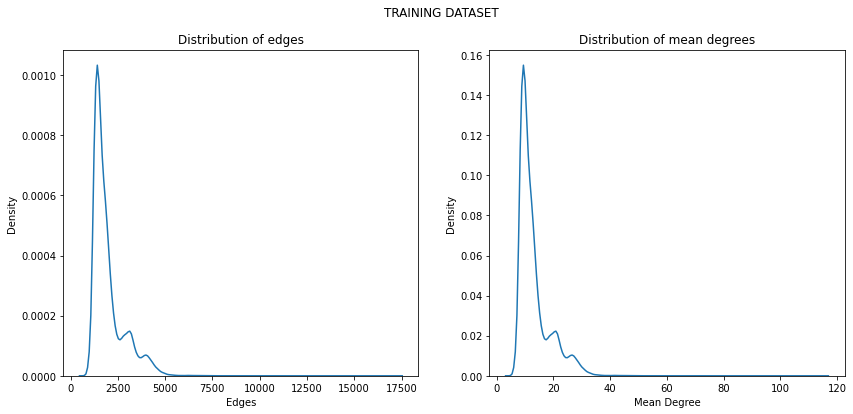

In [19]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(14,6))
sns.kdeplot(np.asarray(train_graphs_info['edges']), ax=ax0)
sns.kdeplot(np.asarray(train_graphs_info['mean_degree']), ax=ax1)
plt.suptitle('TRAINING DATASET')
ax0.set_title('Distribution of edges')
ax0.set_xlabel('Edges')
ax1.set_title('Distribution of mean degrees')
ax1.set_xlabel('Mean Degree')

Text(0.5, 0, 'Mean Degree')

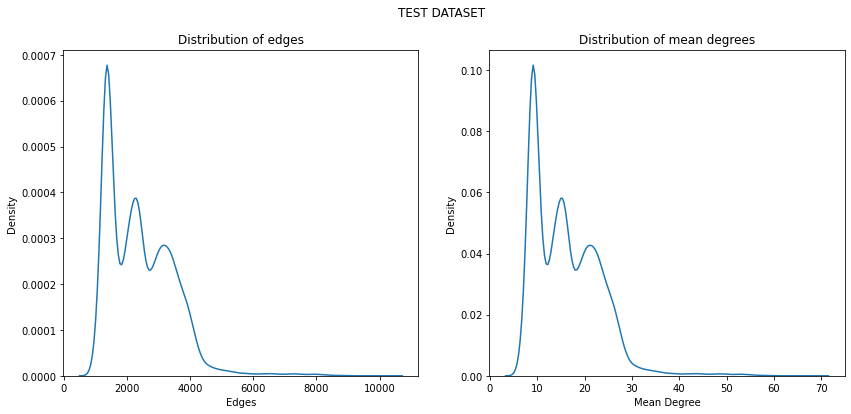

In [20]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(14,6))
sns.kdeplot(np.asarray(test_graphs_info['edges']), ax=ax0)
sns.kdeplot(np.asarray(test_graphs_info['mean_degree']), ax=ax1)
plt.suptitle('TEST DATASET')
ax0.set_title('Distribution of edges')
ax0.set_xlabel('Edges')
ax1.set_title('Distribution of mean degrees')
ax1.set_xlabel('Mean Degree')

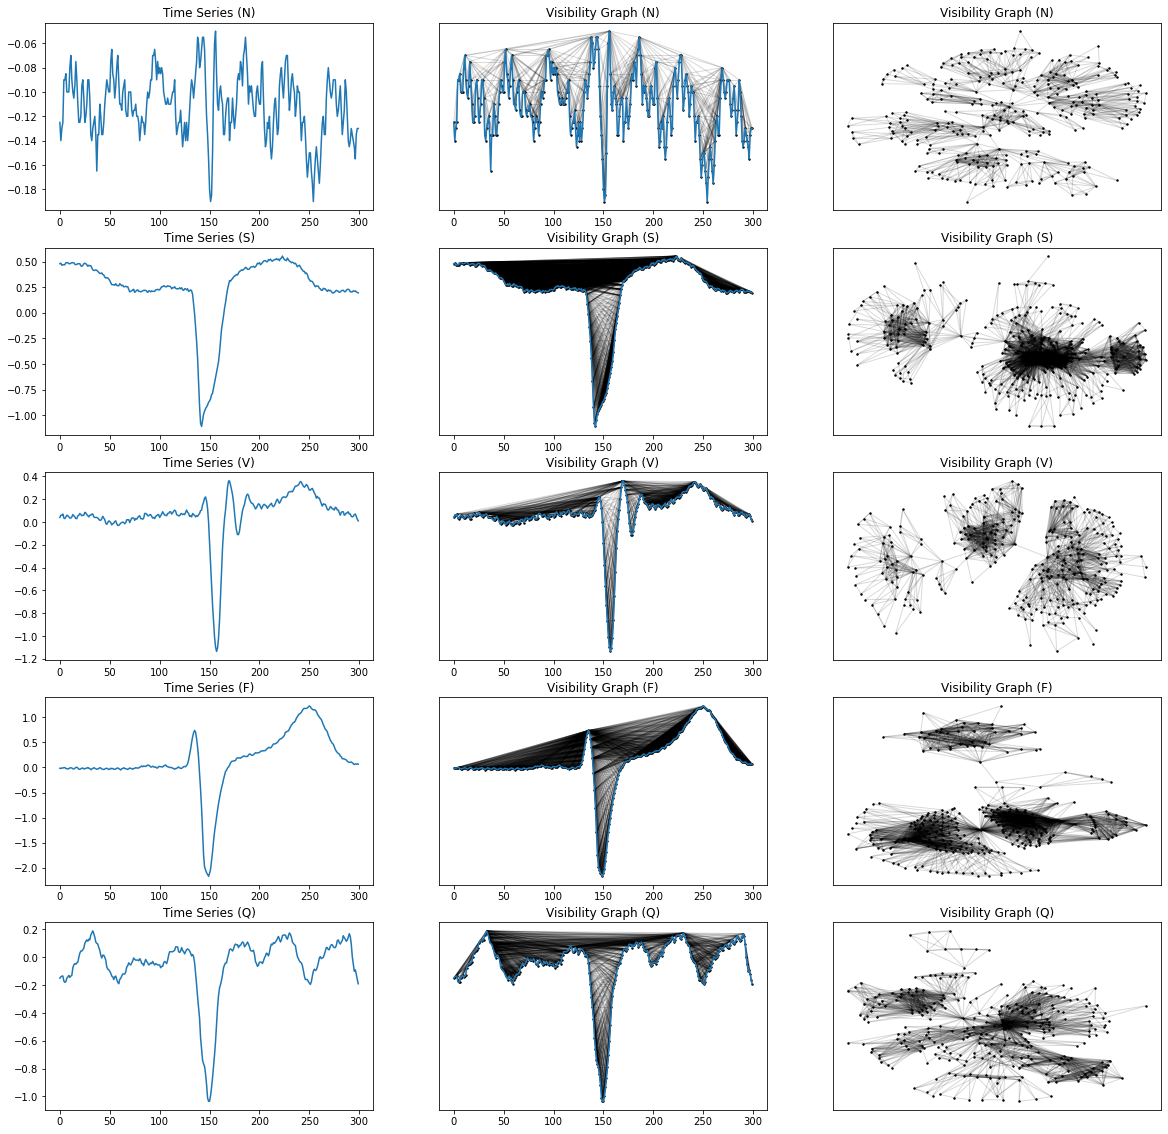

In [21]:
classes_beats = ['N','S','V','F','Q']

fig, ax = plt.subplots(5,3, figsize=(20,20))

for row in range(len(ax)):           
    for col in range(len(ax[row])):            
        if col == 0:                
            beat = dict_beats_train[classes_beats[row]][5]
            g = NaturalVG(directed=None).build(beat)
            g_nx = g.as_networkx()

            ax[row][col].plot(beat)
            ax[row][col].set_title('Time Series (' + classes_beats[row] + ')')

            graph_plot_options = {'with_labels': False,
                                  'node_size': 2,
                                  'node_color': [(0, 0, 0, 1)],
                                  'edge_color': [(0, 0, 0, 0.15)]}

            nx.draw_networkx(g_nx, ax=ax[row][col+1], pos=g.node_positions(), **graph_plot_options)
            ax[row][col+1].tick_params(bottom=True, labelbottom=True)
            ax[row][col+1].plot(beat)
            ax[row][col+1].set_title('Visibility Graph ' + '(' + classes_beats[row] + ')')

            nx.draw_networkx(g_nx, ax=ax[row][col+2], pos=nx.kamada_kawai_layout(g_nx), **graph_plot_options)
            ax[row][col+2].set_title('Visibility Graph ' + '(' + classes_beats[row] + ')')
        else:
            break

plt.savefig('../Images/beats_graphs.pdf', dpi=600)

<div class="alert alert-block alert-info">
    <h1>Building Graph Neural Network</h1>
 </div>

## GCN Modules

In [22]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')

In [23]:
class GCN2(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN2, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)
        self.conv3 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.conv3(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')

In [24]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats-10, 'mean')
        self.conv3 = SAGEConv(h_feats-10, h_feats-25, 'mean')
        self.conv4 = SAGEConv(h_feats-25, num_classes, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.conv3(g,h)
        h = F.relu(h)
        h = self.conv4(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')

In [25]:
#class GraphGAT(nn.Module):
#    def __init__(self, in_feats, h_feats, num_classes):
#        super(GraphGAT, self).__init__()
#        self.conv1 = GATConv(in_feats, h_feats,num_heads=3, attn_drop=0.4)
#        self.conv2 = GATConv(h_feats, h_feats,num_heads=3, attn_drop=0.4)
#        self.conv3 = GATConv(h_feats,num_classes,num_heads=1)
#    
#    def forward(self, g, in_feat):
#        h = self.conv1(g, in_feat)
#        h = F.relu(h)
#        h = self.conv2(g, h)
#        h = F.relu(h)
#        h = self.conv3(g, h)
#        g.ndata['h'] = h
#        return dgl.mean_nodes(g, 'h')

In [26]:
#divide the training and test dataset in batches with size of 64
train_dataloader = GraphDataLoader(dataset_train,
                                   batch_size=64,
                                   drop_last=False,
                                   shuffle=True)

test_dataloader = GraphDataLoader(dataset_test,
                                   batch_size=64,
                                   drop_last=False,
                                   shuffle=True)

## GCN (02 convolutional layers)

In [249]:
model = GCN(2,20, 3)
optimizer = th.optim.Adam(model.parameters(), lr=0.01)

pred_train_label = []
true_train_label = []
pred_test_label = []
true_test_label = []
acc_train_gcn = []
loss_train_gcn = []
num_correct_train = 0
num_tests_train = 0
num_correct_test = 0
num_tests_test = 0
tag = True

for epoch in range(100):
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        if tag:         
            pred_train_label.extend(pred.argmax(1))
            true_train_label.extend(labels)
        num_correct_train += (pred.argmax(1) == labels).sum().item()
        num_tests_train += len(labels)
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tag = False
    loss_train_gcn.append(loss)
    acc_train_gcn.append(num_correct_train / num_tests_train)
    
        
print('Train accuracy:', np.array(acc_train_gcn).mean())
        
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata['attr'].float())
    num_correct_test += (pred.argmax(1) == labels).sum().item()
    num_tests_test += len(labels)
    pred_test_label.extend(pred.argmax(1))
    true_test_label.extend(labels)

print('Test accuracy:', num_correct_test / num_tests_test)

Train accuracy: 0.7436941917521256
Test accuracy: 0.5711803400769517


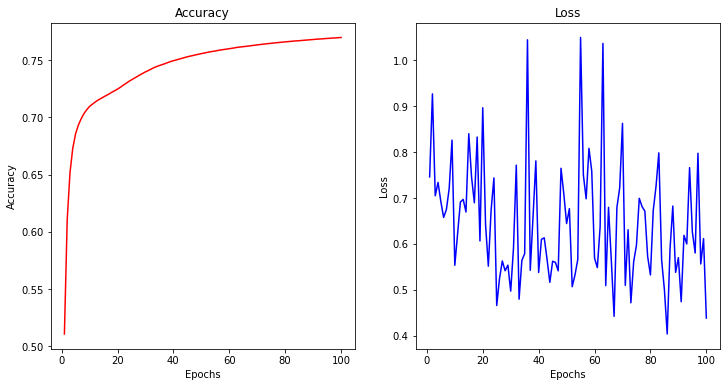

In [251]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(range(1,101), acc_train_gcn, 'r', label='Training accuracy')
ax[1].plot(range(1,101), loss_train_gcn, 'b', label='Training Loss')
ax[0].set_title('Accuracy')
ax[1].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Loss')
plt.show()

In [279]:
print(f'Accuracy: {np.array(acc_train_gcn).mean():.3f} ({np.array(acc_train_gcn).std():.3f})')
print(f'Loss: {np.array([float(i) for i in loss_train_gcn]).mean():.3f} ({np.array([float(i) for i in loss_train_gcn]).std():.3f})')

Accuracy: 0.744 (0.036)
Loss: 0.646 (0.128)


In [252]:
print(classification_report(true_train_label, pred_train_label, zero_division=0))

              precision    recall  f1-score   support

           0       0.57      0.15      0.23      3000
           1       0.00      0.00      0.00       944
           2       0.50      0.93      0.65      3788

    accuracy                           0.51      7732
   macro avg       0.36      0.36      0.29      7732
weighted avg       0.47      0.51      0.41      7732



In [253]:
print(classification_report(true_test_label, pred_test_label, zero_division=0))

              precision    recall  f1-score   support

           0       0.75      0.57      0.65      3000
           1       0.77      0.03      0.06      1837
           2       0.50      0.88      0.63      3220

    accuracy                           0.57      8057
   macro avg       0.67      0.49      0.45      8057
weighted avg       0.65      0.57      0.51      8057



Text(609.9818181818181, 0.5, 'True label')

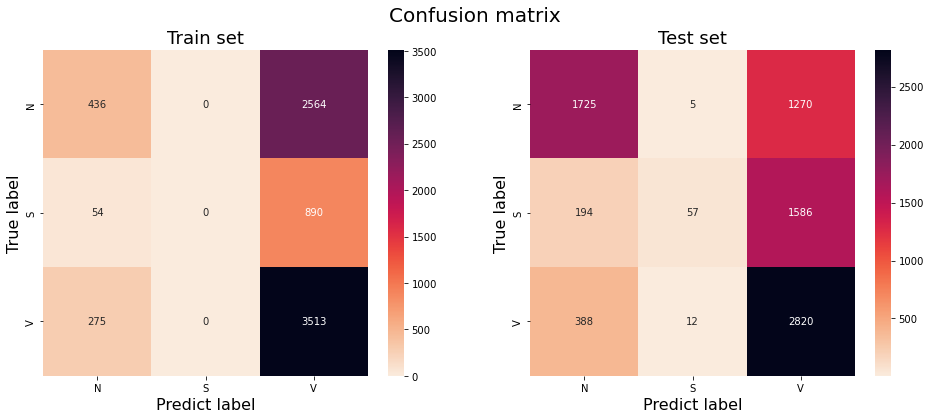

In [254]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

matrix_train_gcn = confusion_matrix(true_train_label, pred_train_label) 
matrix_test_gcn = confusion_matrix(true_test_label, pred_test_label)

sns.heatmap(matrix_train_gcn, ax=ax[0],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r',)
sns.heatmap(matrix_test_gcn, ax=ax[1],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r')
plt.suptitle('Confusion matrix', fontsize=20)
ax[0].set_title('Train set', fontsize=18)
ax[0].set_xlabel('Predict label', fontsize=16)
ax[0].set_ylabel('True label', fontsize=16)
ax[1].set_title('Test set', fontsize=18)
ax[1].set_xlabel('Predict label', fontsize=16)
ax[1].set_ylabel('True label', fontsize=16)

## GCN (03 convolutional layers)

In [255]:
model = GCN2(2,20, 3)
optimizer = th.optim.Adam(model.parameters(), lr=0.01)

pred_train_label = []
true_train_label = []
pred_test_label = []
true_test_label = []
acc_train_gcn2 = []
loss_train_gcn2 = []
num_correct_train = 0
num_tests_train = 0
num_correct_test = 0
num_tests_test = 0
tag = True

for epoch in range(100):
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        if tag:         
            pred_train_label.extend(pred.argmax(1))
            true_train_label.extend(labels)
        num_correct_train += (pred.argmax(1) == labels).sum().item()
        num_tests_train += len(labels)
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tag = False
    loss_train_gcn2.append(loss)
    acc_train_gcn2.append(num_correct_train / num_tests_train)
    
        
print('Train accuracy:', np.array(acc_train_gcn2).mean())
        
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata['attr'].float())
    num_correct_test += (pred.argmax(1) == labels).sum().item()
    num_tests_test += len(labels)
    pred_test_label.extend(pred.argmax(1))
    true_test_label.extend(labels)

print('Test accuracy:', num_correct_test / num_tests_test)

C:\Users\rafae\miniconda3\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Train accuracy: 0.8032971294917374
Test accuracy: 0.7116792850937074


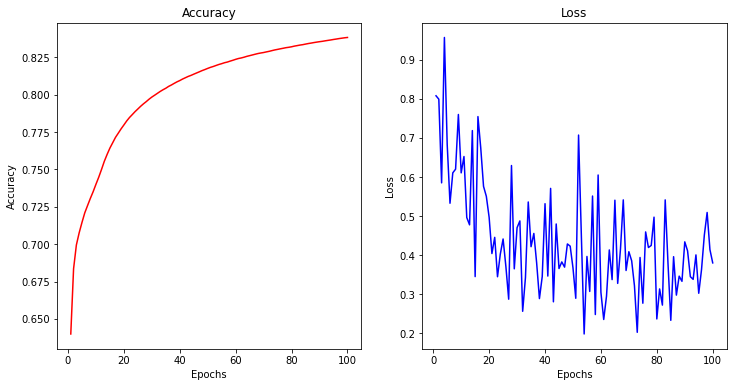

In [256]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(range(1,101), acc_train_gcn2, 'r', label='Training accuracy')
ax[1].plot(range(1,101), loss_train_gcn2, 'b', label='Training Loss')
ax[0].set_title('Accuracy')
ax[1].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Loss')
plt.show()

In [280]:
print(f'Accuracy: {np.array(acc_train_gcn2).mean():.3f} ({np.array(acc_train_gcn2).std():.3f})')
print(f'Loss: {np.array([float(i) for i in loss_train_gcn2]).mean():.3f} ({np.array([float(i) for i in loss_train_gcn2]).std():.3f})')

Accuracy: 0.803 (0.039)
Loss: 0.440 (0.145)


In [257]:
print(classification_report(true_train_label, pred_train_label, zero_division=0))

              precision    recall  f1-score   support

           0       0.75      0.49      0.59      3000
           1       0.12      0.01      0.02       944
           2       0.61      0.91      0.73      3788

    accuracy                           0.64      7732
   macro avg       0.49      0.47      0.45      7732
weighted avg       0.60      0.64      0.59      7732



In [258]:
print(classification_report(true_test_label, pred_test_label, zero_division=0))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3000
           1       0.72      0.07      0.13      1837
           2       0.62      0.87      0.72      3220

    accuracy                           0.71      8057
   macro avg       0.73      0.62      0.58      8057
weighted avg       0.72      0.71      0.65      8057



Text(609.9818181818181, 0.5, 'True label')

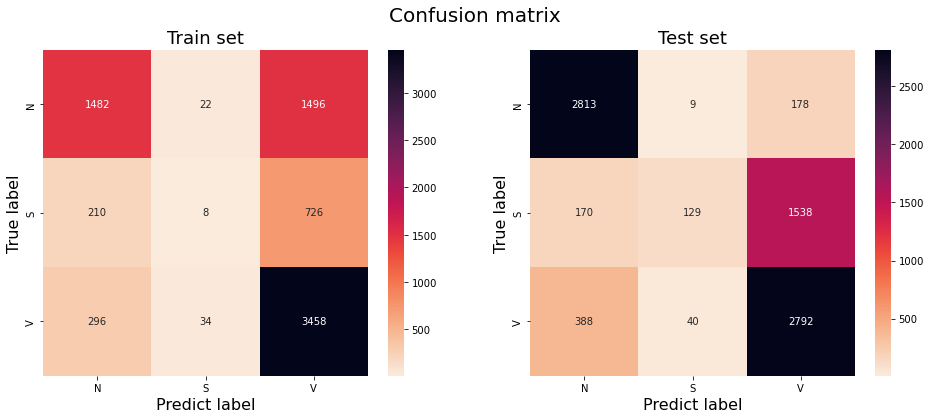

In [259]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

matrix_train_gcn = confusion_matrix(true_train_label, pred_train_label) 
matrix_test_gcn = confusion_matrix(true_test_label, pred_test_label)

sns.heatmap(matrix_train_gcn, ax=ax[0],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r',)
sns.heatmap(matrix_test_gcn, ax=ax[1],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r')
plt.suptitle('Confusion matrix', fontsize=20)
ax[0].set_title('Train set', fontsize=18)
ax[0].set_xlabel('Predict label', fontsize=16)
ax[0].set_ylabel('True label', fontsize=16)
ax[1].set_title('Test set', fontsize=18)
ax[1].set_xlabel('Predict label', fontsize=16)
ax[1].set_ylabel('True label', fontsize=16)

## GCN (GraphSAGE)

In [260]:
model = GraphSAGE(2,30,3)
optimizer = th.optim.Adam(model.parameters(), lr=0.01)

pred_train_label = []
true_train_label = []
pred_test_label = []
true_test_label = []
acc_train_gcnSage = []
loss_train_gcnSage = []
num_correct_train = 0
num_tests_train = 0
num_correct_test = 0
num_tests_test = 0
tag = True

for epoch in range(100):
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        if tag:         
            pred_train_label.extend(pred.argmax(1))
            true_train_label.extend(labels)
        num_correct_train += (pred.argmax(1) == labels).sum().item()
        num_tests_train += len(labels)
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tag = False
    loss_train_gcnSage.append(loss)
    acc_train_gcnSage.append(num_correct_train / num_tests_train)
    
        
print('Train accuracy:', np.array(acc_train_gcnSage).mean())
        
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata['attr'].float())
    num_correct_test += (pred.argmax(1) == labels).sum().item()
    num_tests_test += len(labels)
    pred_test_label.extend(pred.argmax(1))
    true_test_label.extend(labels)

print('Test accuracy:', num_correct_test / num_tests_test)

C:\Users\rafae\miniconda3\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Train accuracy: 0.8751223387361756
Test accuracy: 0.7571056224401141


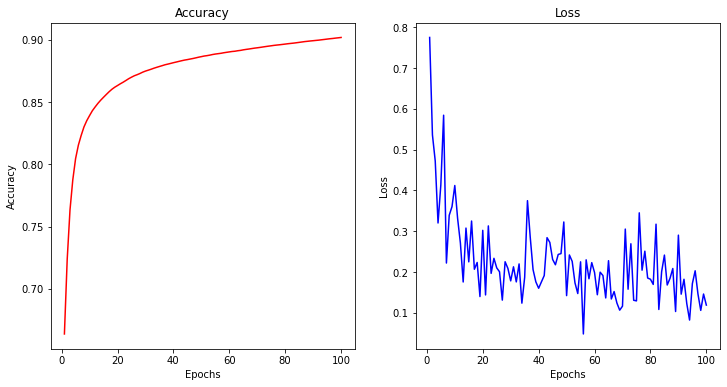

In [261]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(range(1,101), acc_train_gcnSage, 'r')
ax[1].plot(range(1,101), loss_train_gcnSage, 'b')
ax[0].set_title('Accuracy')
ax[1].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Loss')
plt.show()

In [281]:
print(f'Accuracy: {np.array(acc_train_gcnSage).mean():.3f} ({np.array(acc_train_gcnSage).std():.3f})')
print(f'Loss: {np.array([float(i) for i in loss_train_gcnSage]).mean():.3f} ({np.array([float(i) for i in loss_train_gcnSage]).std():.3f})')

Accuracy: 0.875 (0.036)
Loss: 0.224 (0.107)


In [262]:
print(classification_report(true_train_label, pred_train_label, zero_division=0))

              precision    recall  f1-score   support

           0       0.75      0.66      0.71      3000
           1       0.14      0.06      0.08       944
           2       0.66      0.81      0.73      3788

    accuracy                           0.66      7732
   macro avg       0.52      0.51      0.50      7732
weighted avg       0.63      0.66      0.64      7732



In [263]:
print(classification_report(true_test_label, pred_test_label, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3000
           1       0.47      0.19      0.27      1837
           2       0.65      0.87      0.74      3220

    accuracy                           0.76      8057
   macro avg       0.70      0.68      0.67      8057
weighted avg       0.73      0.76      0.73      8057



Text(609.9818181818181, 0.5, 'True label')

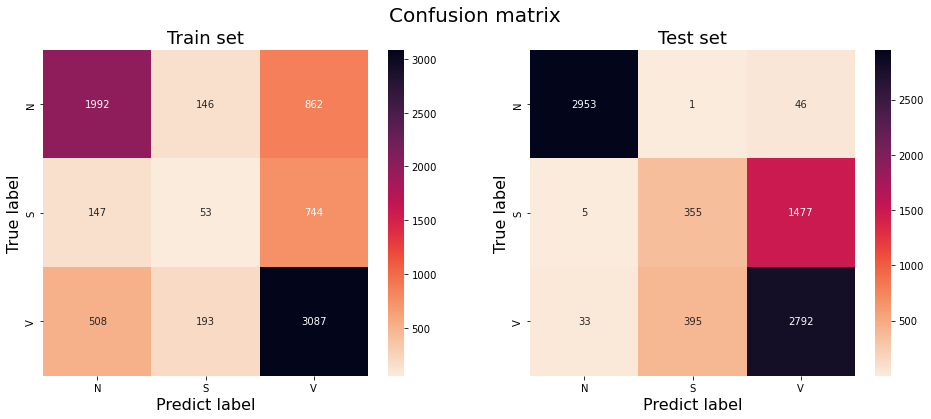

In [264]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

matrix_train_gcn = confusion_matrix(true_train_label, pred_train_label) 
matrix_test_gcn = confusion_matrix(true_test_label, pred_test_label)

sns.heatmap(matrix_train_gcn, ax=ax[0],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r',)
sns.heatmap(matrix_test_gcn, ax=ax[1],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r')
plt.suptitle('Confusion matrix', fontsize=20)
ax[0].set_title('Train set', fontsize=18)
ax[0].set_xlabel('Predict label', fontsize=16)
ax[0].set_ylabel('True label', fontsize=16)
ax[1].set_title('Test set', fontsize=18)
ax[1].set_xlabel('Predict label', fontsize=16)
ax[1].set_ylabel('True label', fontsize=16)

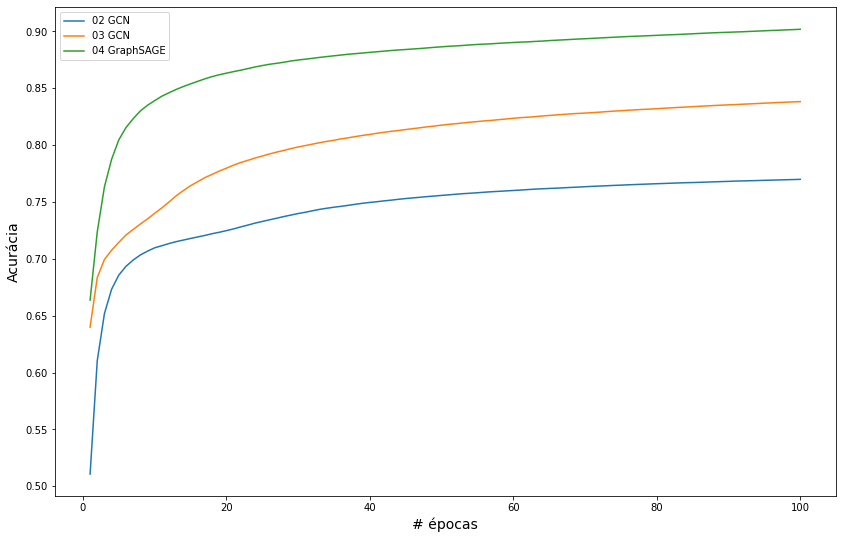

In [285]:
plt.figure(figsize=(14,9))
plt.plot(range(1,101), acc_train_gcn, label='02 GCN')
plt.plot(range(1,101), acc_train_gcn2, label='03 GCN')
plt.plot(range(1,101), acc_train_gcnSage, label='04 GraphSAGE')
plt.xlabel('# épocas', fontsize=14)
plt.ylabel('Acurácia', fontsize=14)
plt.legend()
plt.savefig('acuracias.pdf', dpi=600)
plt.show()

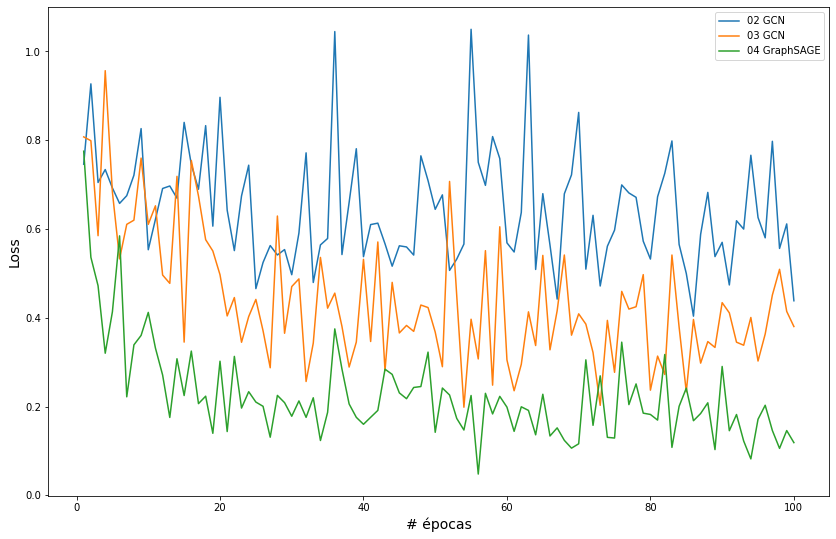

In [286]:
plt.figure(figsize=(14,9))
plt.plot(range(1,101), loss_train_gcn, label='02 GCN')
plt.plot(range(1,101), loss_train_gcn2, label='03 GCN')
plt.plot(range(1,101), loss_train_gcnSage, label='04 GraphSAGE')
plt.xlabel('# épocas', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.savefig('loss.pdf', dpi=600)
plt.show()

# Testing with DS2 as training set

## GCN (02 convolutional layers)

In [27]:
model = GCN(2,20, 3)
optimizer = th.optim.Adam(model.parameters(), lr=0.01)

pred_train_label = []
true_train_label = []
pred_test_label = []
true_test_label = []
acc_train_gcn = []
loss_train_gcn = []
num_correct_train = 0
num_tests_train = 0
num_correct_test = 0
num_tests_test = 0
tag = True

for epoch in range(100):
    for batched_graph, labels in test_dataloader:
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        if tag:         
            pred_train_label.extend(pred.argmax(1))
            true_train_label.extend(labels)
        num_correct_train += (pred.argmax(1) == labels).sum().item()
        num_tests_train += len(labels)
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tag = False
    loss_train_gcn.append(loss)
    acc_train_gcn.append(num_correct_train / num_tests_train)
    
        
print('Train accuracy:', np.array(acc_train_gcn).mean())
        
for batched_graph, labels in train_dataloader:
    pred = model(batched_graph, batched_graph.ndata['attr'].float())
    num_correct_test += (pred.argmax(1) == labels).sum().item()
    num_tests_test += len(labels)
    pred_test_label.extend(pred.argmax(1))
    true_test_label.extend(labels)

print('Test accuracy:', num_correct_test / num_tests_test)

C:\Users\rafae\miniconda3\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Train accuracy: 0.5989927867441911
Test accuracy: 0.617046042421107


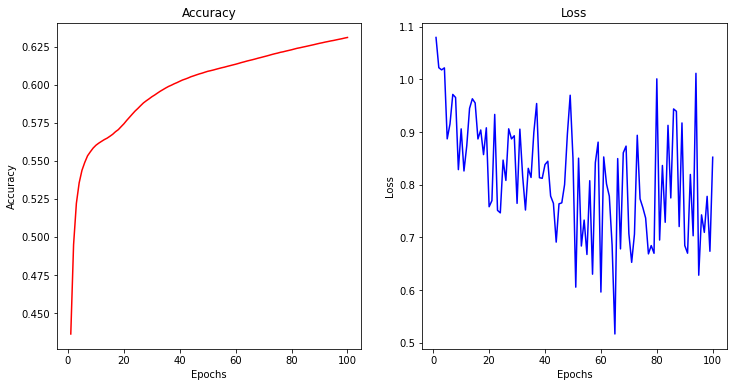

In [28]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(range(1,101), acc_train_gcn, 'r', label='Training accuracy')
ax[1].plot(range(1,101), loss_train_gcn, 'b', label='Training Loss')
ax[0].set_title('Accuracy')
ax[1].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Loss')
plt.show()

In [29]:
print(f'Accuracy: {np.array(acc_train_gcn).mean():.3f} ({np.array(acc_train_gcn).std():.3f})')
print(f'Loss: {np.array([float(i) for i in loss_train_gcn]).mean():.3f} ({np.array([float(i) for i in loss_train_gcn]).std():.3f})')

Accuracy: 0.599 (0.031)
Loss: 0.815 (0.111)


In [30]:
print(classification_report(true_train_label, pred_train_label, zero_division=0))

              precision    recall  f1-score   support

           0       0.49      0.28      0.36      3000
           1       0.00      0.00      0.00      1837
           2       0.42      0.83      0.56      3220

    accuracy                           0.44      8057
   macro avg       0.30      0.37      0.31      8057
weighted avg       0.35      0.44      0.36      8057



In [31]:
print(classification_report(true_test_label, pred_test_label, zero_division=0))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      3000
           1       0.29      0.81      0.43       944
           2       0.85      0.42      0.56      3788

    accuracy                           0.62      7732
   macro avg       0.63      0.68      0.59      7732
weighted avg       0.74      0.62      0.63      7732



Text(609.9818181818181, 0.5, 'True label')

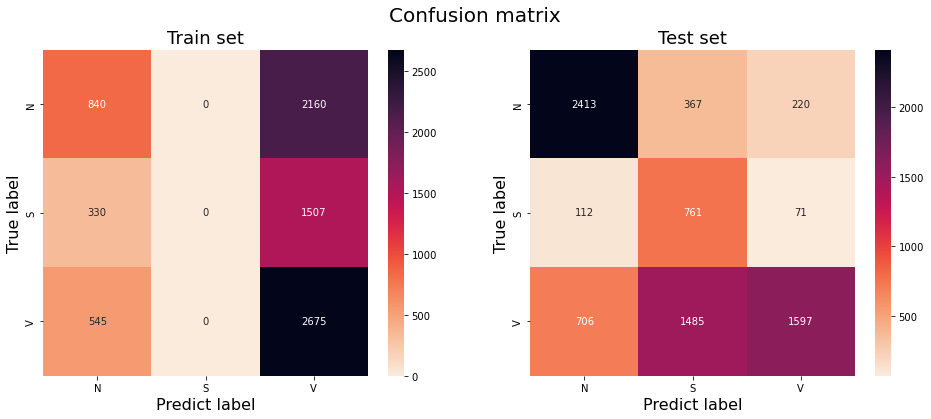

In [32]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

matrix_train_gcn = confusion_matrix(true_train_label, pred_train_label) 
matrix_test_gcn = confusion_matrix(true_test_label, pred_test_label)

sns.heatmap(matrix_train_gcn, ax=ax[0],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r',)
sns.heatmap(matrix_test_gcn, ax=ax[1],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r')
plt.suptitle('Confusion matrix', fontsize=20)
ax[0].set_title('Train set', fontsize=18)
ax[0].set_xlabel('Predict label', fontsize=16)
ax[0].set_ylabel('True label', fontsize=16)
ax[1].set_title('Test set', fontsize=18)
ax[1].set_xlabel('Predict label', fontsize=16)
ax[1].set_ylabel('True label', fontsize=16)

## GCN (03 convolutional layers)

In [33]:
model = GCN2(2,20, 3)
optimizer = th.optim.Adam(model.parameters(), lr=0.01)

pred_train_label = []
true_train_label = []
pred_test_label = []
true_test_label = []
acc_train_gcn2 = []
loss_train_gcn2 = []
num_correct_train = 0
num_tests_train = 0
num_correct_test = 0
num_tests_test = 0
tag = True

for epoch in range(100):
    for batched_graph, labels in test_dataloader:
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        if tag:         
            pred_train_label.extend(pred.argmax(1))
            true_train_label.extend(labels)
        num_correct_train += (pred.argmax(1) == labels).sum().item()
        num_tests_train += len(labels)
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tag = False
    loss_train_gcn2.append(loss)
    acc_train_gcn2.append(num_correct_train / num_tests_train)
    
        
print('Train accuracy:', np.array(acc_train_gcn2).mean())
        
for batched_graph, labels in train_dataloader:
    pred = model(batched_graph, batched_graph.ndata['attr'].float())
    num_correct_test += (pred.argmax(1) == labels).sum().item()
    num_tests_test += len(labels)
    pred_test_label.extend(pred.argmax(1))
    true_test_label.extend(labels)

print('Test accuracy:', num_correct_test / num_tests_test)

C:\Users\rafae\miniconda3\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Train accuracy: 0.7149319353539161
Test accuracy: 0.6736937403000517


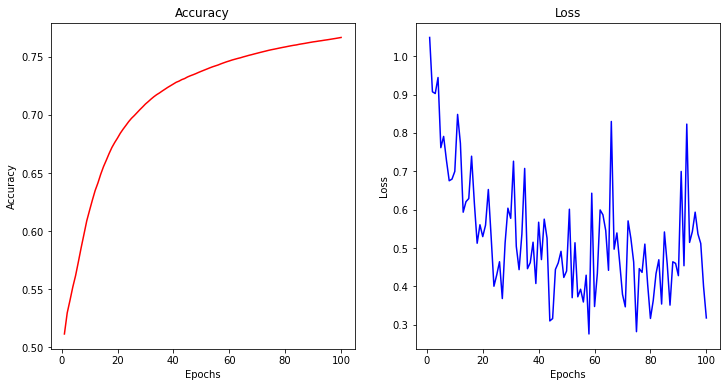

In [34]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(range(1,101), acc_train_gcn2, 'r', label='Training accuracy')
ax[1].plot(range(1,101), loss_train_gcn2, 'b', label='Training Loss')
ax[0].set_title('Accuracy')
ax[1].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Loss')
plt.show()

In [35]:
print(f'Accuracy: {np.array(acc_train_gcn2).mean():.3f} ({np.array(acc_train_gcn2).std():.3f})')
print(f'Loss: {np.array([float(i) for i in loss_train_gcn2]).mean():.3f} ({np.array([float(i) for i in loss_train_gcn2]).std():.3f})')

Accuracy: 0.715 (0.060)
Loss: 0.531 (0.154)


In [36]:
print(classification_report(true_train_label, pred_train_label, zero_division=0))

              precision    recall  f1-score   support

           0       0.59      0.52      0.55      3000
           1       0.25      0.03      0.06      1837
           2       0.48      0.78      0.60      3220

    accuracy                           0.51      8057
   macro avg       0.44      0.44      0.40      8057
weighted avg       0.47      0.51      0.46      8057



In [37]:
print(classification_report(true_test_label, pred_test_label, zero_division=0))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85      3000
           1       0.27      0.51      0.35       944
           2       0.87      0.48      0.62      3788

    accuracy                           0.67      7732
   macro avg       0.63      0.65      0.61      7732
weighted avg       0.75      0.67      0.68      7732



Text(609.9818181818181, 0.5, 'True label')

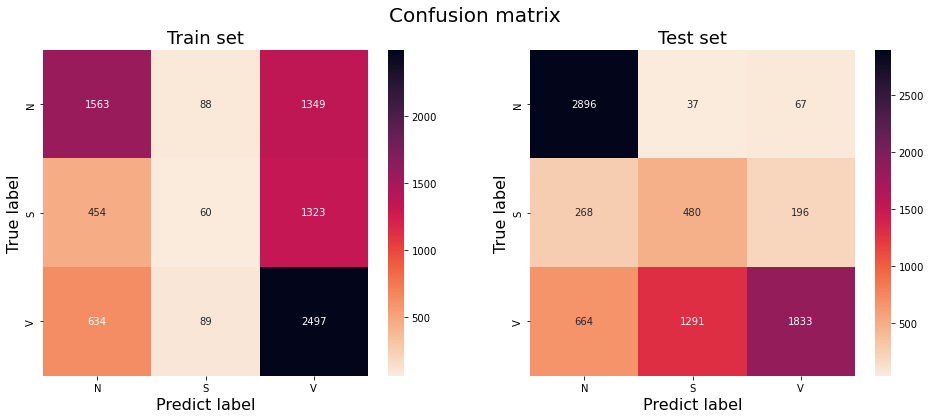

In [38]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

matrix_train_gcn = confusion_matrix(true_train_label, pred_train_label) 
matrix_test_gcn = confusion_matrix(true_test_label, pred_test_label)

sns.heatmap(matrix_train_gcn, ax=ax[0],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r',)
sns.heatmap(matrix_test_gcn, ax=ax[1],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r')
plt.suptitle('Confusion matrix', fontsize=20)
ax[0].set_title('Train set', fontsize=18)
ax[0].set_xlabel('Predict label', fontsize=16)
ax[0].set_ylabel('True label', fontsize=16)
ax[1].set_title('Test set', fontsize=18)
ax[1].set_xlabel('Predict label', fontsize=16)
ax[1].set_ylabel('True label', fontsize=16)

## GCN (GraphSAGE)

In [39]:
model = GraphSAGE(2,30,3)
optimizer = th.optim.Adam(model.parameters(), lr=0.01)

pred_train_label = []
true_train_label = []
pred_test_label = []
true_test_label = []
acc_train_gcnSage = []
loss_train_gcnSage = []
num_correct_train = 0
num_tests_train = 0
num_correct_test = 0
num_tests_test = 0
tag = True

for epoch in range(100):
    for batched_graph, labels in test_dataloader:
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        if tag:         
            pred_train_label.extend(pred.argmax(1))
            true_train_label.extend(labels)
        num_correct_train += (pred.argmax(1) == labels).sum().item()
        num_tests_train += len(labels)
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tag = False
    loss_train_gcnSage.append(loss)
    acc_train_gcnSage.append(num_correct_train / num_tests_train)
    
        
print('Train accuracy:', np.array(acc_train_gcnSage).mean())
        
for batched_graph, labels in train_dataloader:
    pred = model(batched_graph, batched_graph.ndata['attr'].float())
    num_correct_test += (pred.argmax(1) == labels).sum().item()
    num_tests_test += len(labels)
    pred_test_label.extend(pred.argmax(1))
    true_test_label.extend(labels)

print('Test accuracy:', num_correct_test / num_tests_test)

C:\Users\rafae\miniconda3\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Train accuracy: 0.4017692690558396
Test accuracy: 0.48991205380237973


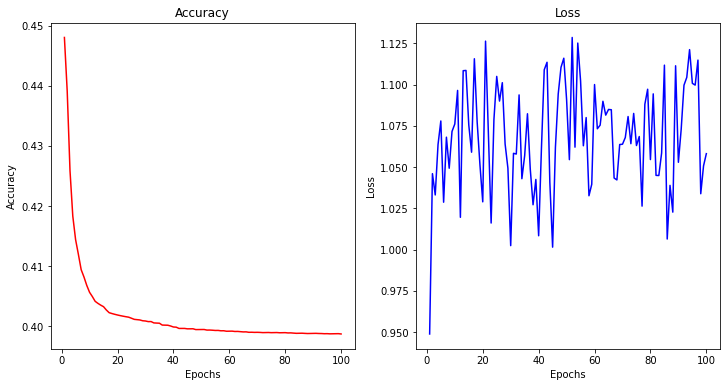

In [40]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(range(1,101), acc_train_gcnSage, 'r')
ax[1].plot(range(1,101), loss_train_gcnSage, 'b')
ax[0].set_title('Accuracy')
ax[1].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Loss')
plt.show()

In [41]:
print(f'Accuracy: {np.array(acc_train_gcnSage).mean():.3f} ({np.array(acc_train_gcnSage).std():.3f})')
print(f'Loss: {np.array([float(i) for i in loss_train_gcnSage]).mean():.3f} ({np.array([float(i) for i in loss_train_gcnSage]).std():.3f})')

Accuracy: 0.402 (0.007)
Loss: 1.069 (0.033)


In [42]:
print(classification_report(true_train_label, pred_train_label, zero_division=0))

              precision    recall  f1-score   support

           0       0.47      0.50      0.48      3000
           1       0.15      0.02      0.03      1837
           2       0.45      0.64      0.53      3220

    accuracy                           0.45      8057
   macro avg       0.36      0.39      0.35      8057
weighted avg       0.39      0.45      0.40      8057



In [43]:
print(classification_report(true_test_label, pred_test_label, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3000
           1       0.00      0.00      0.00       944
           2       0.49      1.00      0.66      3788

    accuracy                           0.49      7732
   macro avg       0.16      0.33      0.22      7732
weighted avg       0.24      0.49      0.32      7732



Text(609.9818181818181, 0.5, 'True label')

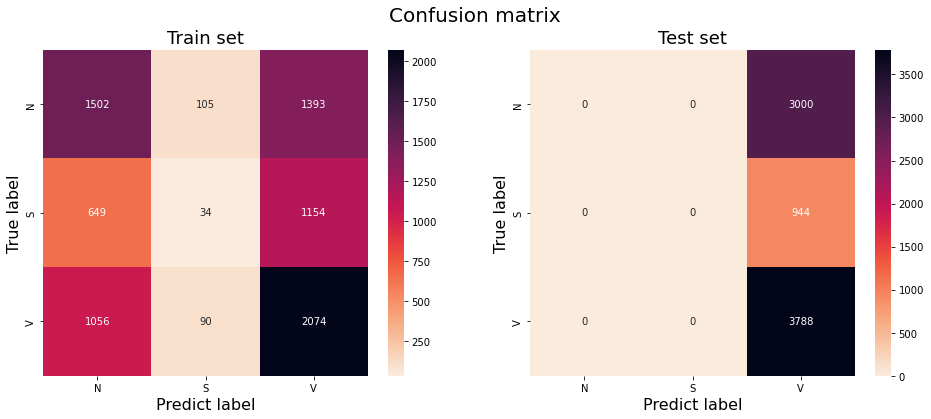

In [44]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

matrix_train_gcn = confusion_matrix(true_train_label, pred_train_label) 
matrix_test_gcn = confusion_matrix(true_test_label, pred_test_label)

sns.heatmap(matrix_train_gcn, ax=ax[0],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r',)
sns.heatmap(matrix_test_gcn, ax=ax[1],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r')
plt.suptitle('Confusion matrix', fontsize=20)
ax[0].set_title('Train set', fontsize=18)
ax[0].set_xlabel('Predict label', fontsize=16)
ax[0].set_ylabel('True label', fontsize=16)
ax[1].set_title('Test set', fontsize=18)
ax[1].set_xlabel('Predict label', fontsize=16)
ax[1].set_ylabel('True label', fontsize=16)

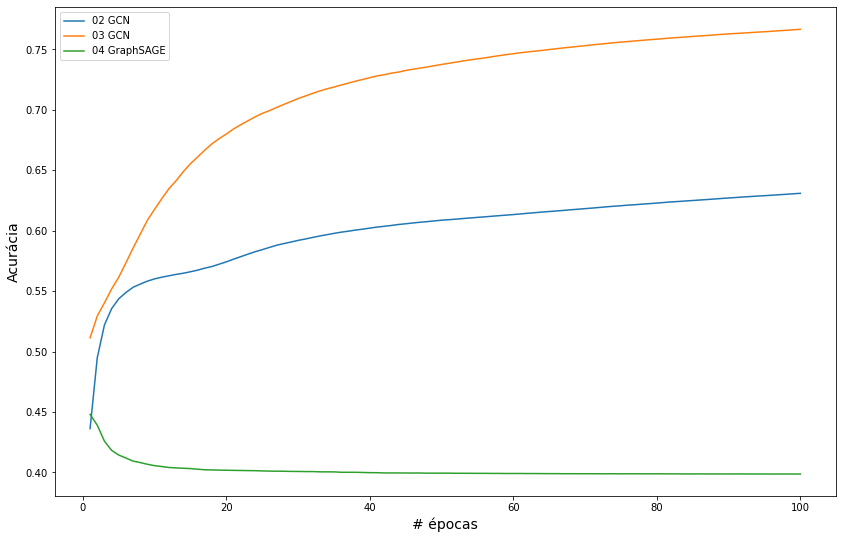

In [45]:
plt.figure(figsize=(14,9))
plt.plot(range(1,101), acc_train_gcn, label='02 GCN')
plt.plot(range(1,101), acc_train_gcn2, label='03 GCN')
plt.plot(range(1,101), acc_train_gcnSage, label='04 GraphSAGE')
plt.xlabel('# épocas', fontsize=14)
plt.ylabel('Acurácia', fontsize=14)
plt.legend()
plt.savefig('acuracias.pdf', dpi=600)
plt.show()

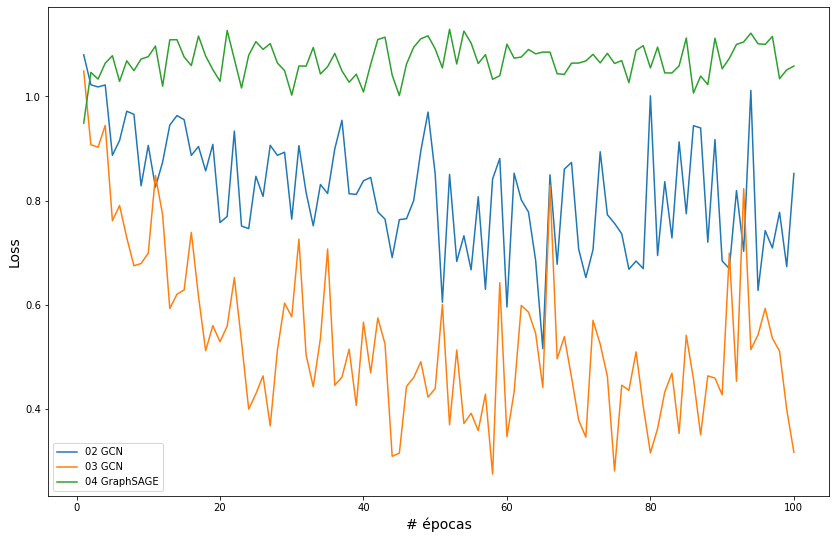

In [46]:
plt.figure(figsize=(14,9))
plt.plot(range(1,101), loss_train_gcn, label='02 GCN')
plt.plot(range(1,101), loss_train_gcn2, label='03 GCN')
plt.plot(range(1,101), loss_train_gcnSage, label='04 GraphSAGE')
plt.xlabel('# épocas', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.savefig('loss.pdf', dpi=600)
plt.show()